<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI-Lab2021%5D%20Assignment%201%20OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment:
Preparation:
1. Checkout the notebook 0_Simple_NN.ipynb from Git, which describes how to
setup a simple feedforward network on some fake data. Try to understand
everything and execute the notebook. Ask on the chat if sth. is unclear.
2. Read through this blog post: https://nextjournal.com/gkoehler/pytorch-mnist
It shows how to work with data loaders, how to load the MNIST dataset and how
training is done in batches (using data loaders). 

Task:
1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog post.
2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in Simple_NN.ipynb).
For training on the MNIST dataset you need to change the following:
  - Adjust the size of the input layer to be able to take in the MNIST data (hint: you
must adjust the tensor format from the MNIST data into a flat structure).
  - Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.
3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog
but without the test loss).
4. Test the network on the MNIST test data and give out accuracy and loss.
5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not except too much improvement on
this small data set).
6. Repeat step 1. to 4. and see what happens when you try out:
  1. Two different hidden layer sizes.
  2. Using a normal softmax as activation function together with a CrossEntropyLoss.

In [22]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Parameter

In [16]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Download MNIST Dataset

In [18]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Explore Dataset

In [19]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [20]:
example_data.shape

torch.Size([1000, 1, 28, 28])

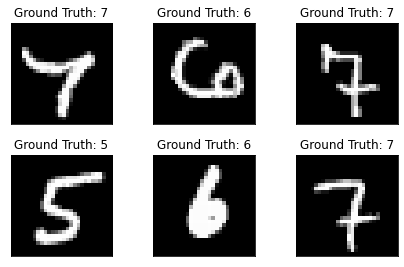

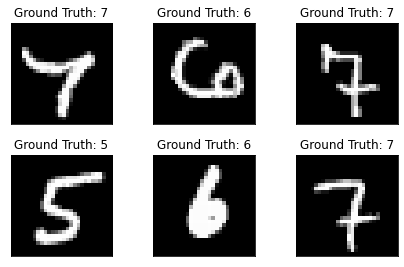

In [23]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Create Neural Network

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# Training

In [28]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [27]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# Evaluation

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig